# Text Classifier for sentiment analysis using twets from different gaming platforms

Natural Language Processing

Assignment 1

Submitted to: Dr Aneerav Sukhoo

Submitted by: 

Sutdent 1: Harsha Ramjee 
Student ID: 2002609

Student 2: Virikshit Sembhoo
Student ID: 2023151

Course Code: SIS 6223

Date of Submission: 20 June 2022

# Dataset and problem 

The dataset used for this assignment was picked from kaggle website. The dataset is public and can be accessed using the following link: 
https://www.kaggle.com/datasets/jp797498e/twitter-entity-sentiment-analysis

There were two csv files available, both having same structure.

Below are the features present in the dataset.

Tweet ID: ID of the tweet
Entity: Platform the tweet is referring to
Sentiment: The class to which the tweet belongs to
Tweet Content: The texts of the tweet

At first when browsing through the tweets it is easy to confuse negative and positive. This dataset is tricky, using SentimentIntensityAnalyzer library from Vader sentiment analysis, it was found that many positive classes are negative as per this library. For e.g 'I'm coming to kill all of you', in the context of gaming this is positive sentiment. This is why this dataset seemed very interesting and just using libraries will not be helpful for a good model.

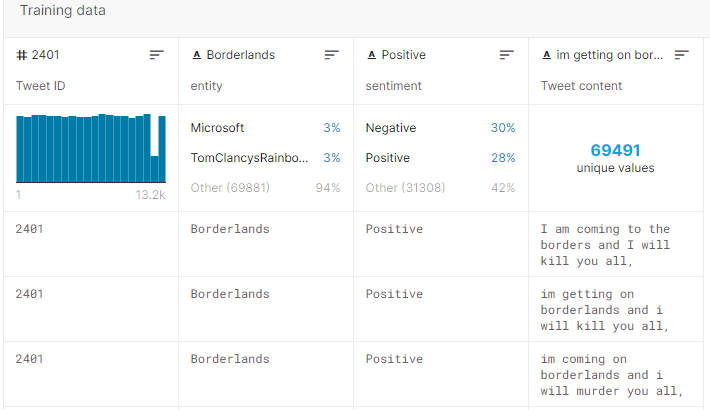

# Importing libraries
Below libraries were imported and explanations will be provided at code blocks where the libraries are being used.

In [730]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import xticks
from nltk.corpus import stopwords
import nltk
import re
from nltk.stem import WordNetLemmatizer, PorterStemmer
import string
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from collections import defaultdict
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
import tensorflow as tf
from sklearn.metrics import f1_score
from wordcloud import WordCloud,STOPWORDS
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from numpy import array
from numpy import asarray
from numpy import zeros
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense,Flatten,Embedding,Activation,Dropout
from keras.layers import Conv1D,MaxPooling1D,GlobalMaxPooling1D,LSTM

# Loading the data
Pandas library was used to load the two datasets that were available. One dataset is twitter_training.csv and the other one is twitter_validation.csv

In [731]:
# load train and test datasets
columns = ["Id","Entity","Target","Text"]
data= pd.read_csv('twitter_training.csv',names=columns,header=None)
val=pd.read_csv('twitter_validation.csv',names=columns,header=None)

# Details about the datasets
we can see that the train dataset consisted of 74682 rows and 4 columns and validation dataset consisted of 1000 rows and 4 columns

In [732]:
# check the no. of rows and columns in the dataset
data.shape, val.shape

((74682, 4), (1000, 4))

In [733]:
#first five rows of the dataset
val.head()

,Id,Entity,Target,Text
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,4433,Google,Neutral,Now the President is slapping Americans in the...


In [734]:
#first five rows of the dataset
data.head()

,Id,Entity,Target,Text
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


# Data Cleaning

In [735]:
#check for null values
data.isnull().sum().sort_values(ascending = False)

Text      686
Id          0
Entity      0
Target      0
dtype: int64

In [736]:
#we remove the null value that we found
data = data.dropna()

In [737]:
#will keep only relevant features that will be used by the classifier
data = data[["Text","Target"]]

In [738]:
#will keep only relevant features that will be used by the classifier
val = val[["Text","Target"]]

In [739]:
#Need to remove duplicates to ensure have better accuracy
data= data.drop_duplicates()

In [740]:
#Need to remove duplicates to ensure have better accuracy
val= val.drop_duplicates()

In [741]:
#viewing cleaned dataset
data

,Text,Target
0,im getting on borderlands and i will murder yo...,Positive
1,I am coming to the borders and I will kill you...,Positive
2,im getting on borderlands and i will kill you ...,Positive
3,im coming on borderlands and i will murder you...,Positive
4,im getting on borderlands 2 and i will murder ...,Positive
...,...,...
74677,Just realized that the Windows partition of my...,Positive
74678,Just realized that my Mac window partition is ...,Positive
74679,Just realized the windows partition of my Mac ...,Positive
74680,Just realized between the windows partition of...,Positive


In [742]:
#viewing cleaned dataset
val

,Text,Target
0,I mentioned on Facebook that I was struggling ...,Irrelevant
1,BBC News - Amazon boss Jeff Bezos rejects clai...,Neutral
2,@Microsoft Why do I pay for WORD when it funct...,Negative
3,"CSGO matchmaking is so full of closet hacking,...",Negative
4,Now the President is slapping Americans in the...,Neutral
...,...,...
995,⭐️ Toronto is the arts and culture capital of ...,Irrelevant
996,tHIS IS ACTUALLY A GOOD MOVE TOT BRING MORE VI...,Irrelevant
997,Today sucked so it’s time to drink wine n play...,Positive
998,Bought a fraction of Microsoft today. Small wins.,Positive


# Visualisations
It will be interesting to do some data visualisation to get some insights concerning the dataset

First let's check the class distribution. It is always good to have a balanced class distribution when build a model to predict a particular class, else the model will be a biased one.

<AxesSubplot:xlabel='Target', ylabel='count'>

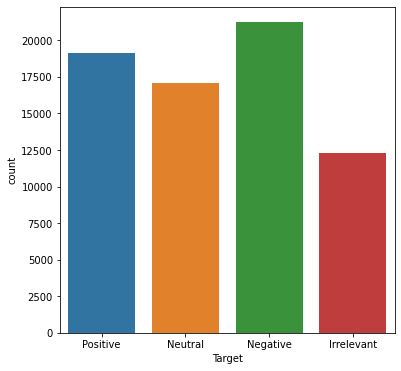

In [743]:
#checking the class, and we can notice that there is a class imbalance, data consists of more negative class
sns.countplot(x="Target",data=data)

In [744]:
# check class distribution, we can see that Neutral and Irrelevant have a dataset with class imbalance
print("No. of Positive Tweets (Target = 'Positive''):",len(data[data["Target"]=='Positive']))
print("No. of Positive Tweets (Target = 'Negative''):",len(data[data["Target"]=='Negative']))
print("No. of Positive Tweets (Target = 'Neutral''):",len(data[data["Target"]=='Neutral']))
print("No. of Positive Tweets (Target = 'Irrelevant''):",len(data[data["Target"]=='Irrelevant']))

No. of Positive Tweets (Target = 'Positive''): 19138
No. of Positive Tweets (Target = 'Negative''): 21237
No. of Positive Tweets (Target = 'Neutral''): 17110
No. of Positive Tweets (Target = 'Irrelevant''): 12284


Another interesting analysis will be to check the length of tweet by classes. We added a column length to our dataset to and created for bar charts. This analysis allow us to know if length of tweet determines the class.

In [745]:
# we will now check the length of tweets
#we created a new column with length of text
data['length']  = data['Text'].str.len()

In [746]:
data

,Text,Target,length
0,im getting on borderlands and i will murder yo...,Positive,53
1,I am coming to the borders and I will kill you...,Positive,51
2,im getting on borderlands and i will kill you ...,Positive,50
3,im coming on borderlands and i will murder you...,Positive,51
4,im getting on borderlands 2 and i will murder ...,Positive,57
...,...,...,...
74677,Just realized that the Windows partition of my...,Positive,128
74678,Just realized that my Mac window partition is ...,Positive,117
74679,Just realized the windows partition of my Mac ...,Positive,125
74680,Just realized between the windows partition of...,Positive,159


In [747]:
# function to draw histogram
def draw_hist(xlabel, ylabel,title,target,sub,color):
    plt.subplot(1,4,sub)
    plt.hist(data[data.Target==target]["length"],color = color)
    plt.title(title,fontsize=25)
    plt.xlabel(xlabel,fontsize=15)
    plt.ylabel(ylabel,fontsize=15)
    plt.ylim(0,12000)
    plt.grid()

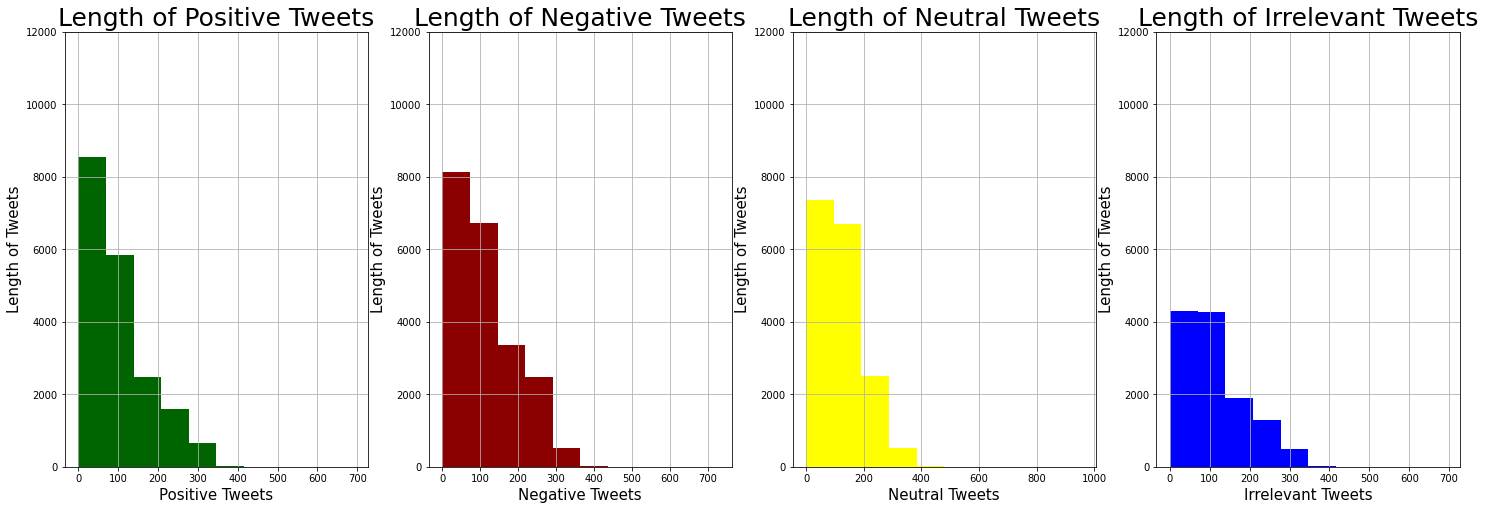

In [748]:
# lets see the distribution of length of tweets real vs fake
plt.figure(figsize = (25,8))
draw_hist("Positive Tweets","Length of Tweets","Length of Positive Tweets",'Positive', 1,"darkgreen")
draw_hist("Negative Tweets","Length of Tweets","Length of Negative Tweets",'Negative', 2,"darkred")
draw_hist("Neutral Tweets","Length of Tweets","Length of Neutral Tweets",'Neutral', 3,"Yellow")
draw_hist("Irrelevant Tweets","Length of Tweets","Length of Irrelevant Tweets",'Irrelevant', 4,"Blue")

In [749]:
# function to draw bar plot
def draw_bar_plot(category,length,xlabel,ylabel,title,sub):
    plt.subplot(2,2,sub)
    plt.bar(category, length)
    plt.legend()
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel(ylabel, fontsize=15)
    plt.title(title, fontsize=15)
    #plt.show()

Target
Neutral       122.222151
Negative      115.132834
Irrelevant    113.335640
Positive      100.481189
Name: length, dtype: float64


C:\Users\Avish\AppData\Local\Temp\ipykernel_3828\2088157662.py:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  [data[data.Target=='Positive'].mean()["length"],
C:\Users\Avish\AppData\Local\Temp\ipykernel_3828\2088157662.py:8: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  data[data.Target=='Negative'].mean()["length"],
C:\Users\Avish\AppData\Local\Temp\ipykernel_3828\2088157662.py:9: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  data[data.Target=='Neutral'].mean()["length"],
C:\Users\A

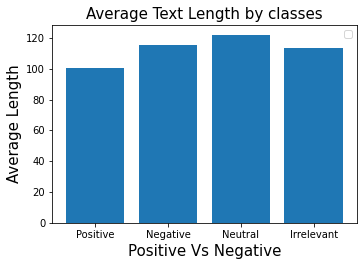

In [750]:
# lets check the average lenght of tweets
print(data.groupby("Target").mean()["length"].sort_values(ascending = False))

# lets visualize the class distribution
plt.figure(figsize = (12,8))
draw_bar_plot(["Positive","Negative","Neutral","Irrelevant"],
              [data[data.Target=='Positive'].mean()["length"],
               data[data.Target=='Negative'].mean()["length"], 
               data[data.Target=='Neutral'].mean()["length"], 
               data[data.Target=='Irrelevant'].mean()["length"]],
              "Positive Vs Negative","Average Length","Average Text Length by classes",1)

Irrelevant tweets tend to be a little longer but almost all tweets length distribution seems to be same and we can say that class is not really affected by tweet length

In [751]:
# lets drop the column
data.drop("length",1,inplace=True)

C:\Users\Avish\AppData\Local\Temp\ipykernel_3828\1549346368.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data.drop("length",1,inplace=True)


# Class reduction
As we have seen, irrelevant and neutral seems to have lowest count and in this model we are going to consider irrelevant and neutral as a single class, there we will have a total of 3 classes; positive, negative and neutral/irrelevant

In [752]:
data.Target = data.Target.apply(lambda x: 'Neutral/Irrelevant' if 'Neutral' in x else x)
data.Target = data.Target.apply(lambda x: 'Neutral/Irrelevant' if 'Irrelevant' in x else x)

In [753]:
val.Target = val.Target.apply(lambda x: 'Neutral/Irrelevant' if 'Neutral' in x else x)
val.Target = val.Target.apply(lambda x: 'Neutral/Irrelevant' if 'Irrelevant' in x else x)

In [754]:
val.head()

,Text,Target
0,I mentioned on Facebook that I was struggling ...,Neutral/Irrelevant
1,BBC News - Amazon boss Jeff Bezos rejects clai...,Neutral/Irrelevant
2,@Microsoft Why do I pay for WORD when it funct...,Negative
3,"CSGO matchmaking is so full of closet hacking,...",Negative
4,Now the President is slapping Americans in the...,Neutral/Irrelevant


<AxesSubplot:xlabel='Target', ylabel='count'>

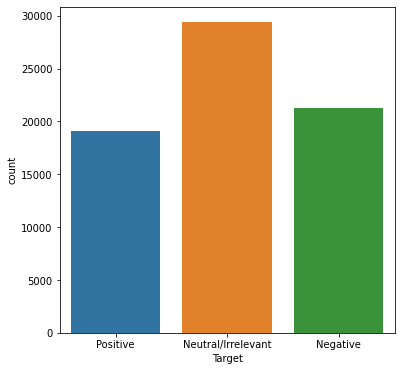

In [755]:
#checking the class, and we can notice that there is a class imbalance, data consists of more negative class
sns.countplot(x="Target",data=data)

In [756]:
#converting classes to numeric 
#we created an empty list and appended values to the list to represent a certain class
sentiment = []

for i in data["Target"]:
    if i == "Positive":
        sentiment.append(1)
    elif (i == "Neutral/Irrelevant"):
        sentiment.append(0)
    else:
        sentiment.append(-1)
data["Sentiment"] = sentiment

# Wordcloud
To view the most commonly used words, we are going to display word cloud for each class?

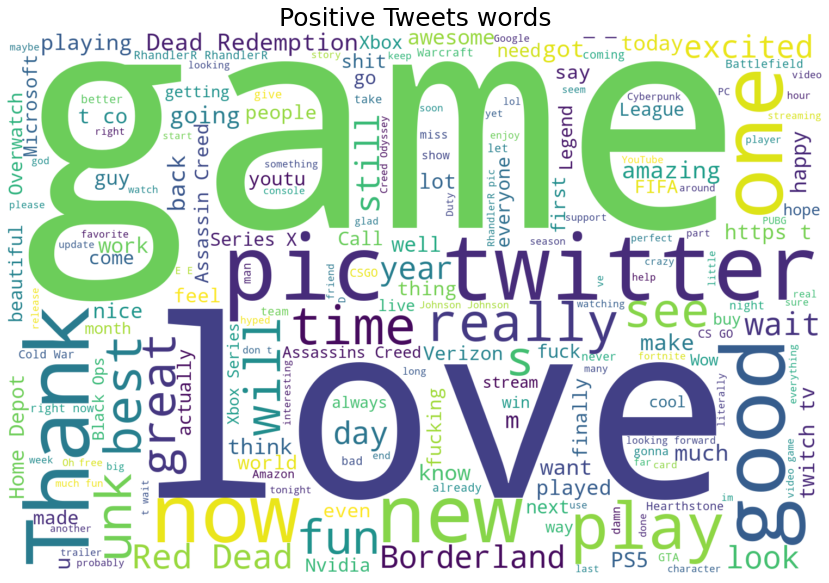

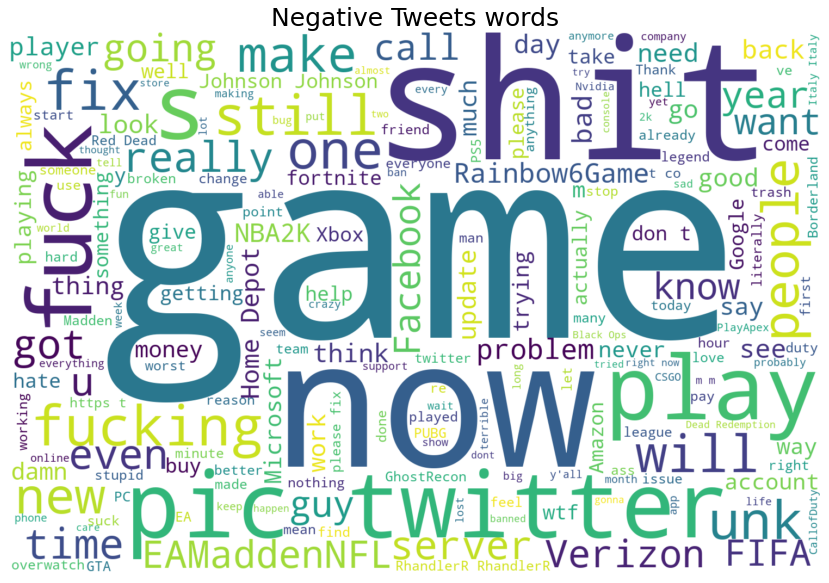

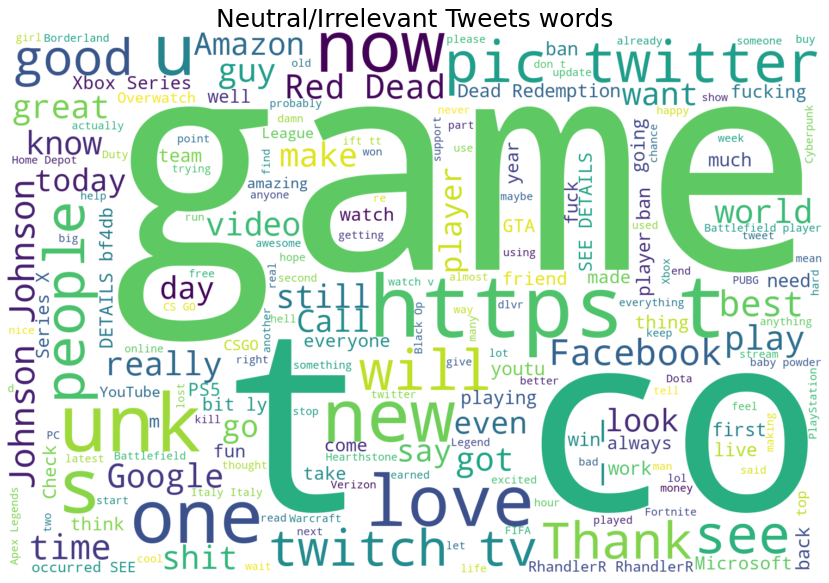

In [757]:
# Generating a word cloud of frequency of text
train_s0 = data[data.Sentiment ==1]
# Generating a word cloud of frequency of text
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white", width=1500, height=1000).generate(" ".join(train_s0['Text']))
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Positive Tweets words",fontsize=25)
plt.axis("off")
plt.show()

# Generating a word cloud of frequency of text
train_s0 = data[data.Sentiment ==-1]
# Generating a word cloud of frequency of text
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white", width=1500, height=1000).generate(" ".join(train_s0['Text']))
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Negative Tweets words",fontsize=25)
plt.axis("off")
plt.show()


# Generating a word cloud of frequency of text
train_s0 = data[data.Sentiment ==0]
# Generating a word cloud of frequency of text
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white", width=1500, height=1000).generate(" ".join(train_s0['Text']))
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Neutral/Irrelevant Tweets words",fontsize=25)
plt.axis("off")
plt.show()

# Stopwords in the text
For text classification, we need to take of very common english words, that can occur several times in a sentence. we are going to use stopwords for this. Below we are going yo visualize list of most used stopwords in our dataset. Charts have been used to display the top 10 most common stopwords in the dataset.

In [758]:
# function to draw graphs for stopwords and punctuations
def draw_bar_n_plot(data,title):
# lets visualize the top 10 stop words
    x,y=zip(*data)

    plt.figure(figsize = (25,10))
    plt.subplot(1,4,1)
    plt.bar(x,y)
    plt.title("Top 10 "+ title,fontsize=25)
    plt.xlabel(title,fontsize=15)
    plt.ylabel("Count",fontsize=15)
    plt.grid()

    plt.subplot(1,2,2)
    plt.plot(x,y,'g')
    plt.title("Top 10 "+ title,fontsize=25)
    plt.xlabel(title,fontsize=15)
    plt.ylabel("Count",fontsize=15)
    plt.grid()

We need to set our stopwords to English since we are concern with an English dataset

In [759]:
#lets save stopwords in a variable
stop = list(stopwords.words("english"))
stop

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [760]:
# stopwords present in the whole dataset
#below code creates an empty list and append words to it when the word is found in the stopword list
sw = []
for message in data.Text:
    for word in message.split():
        if word in stop:
            sw.append(word)


# lets convert the list to a dictinoary which would contain the stop words and their frequency
wordlist = nltk.FreqDist(sw)
# lets save the 10 most frequent stopwords
top10 = wordlist.most_common(10)

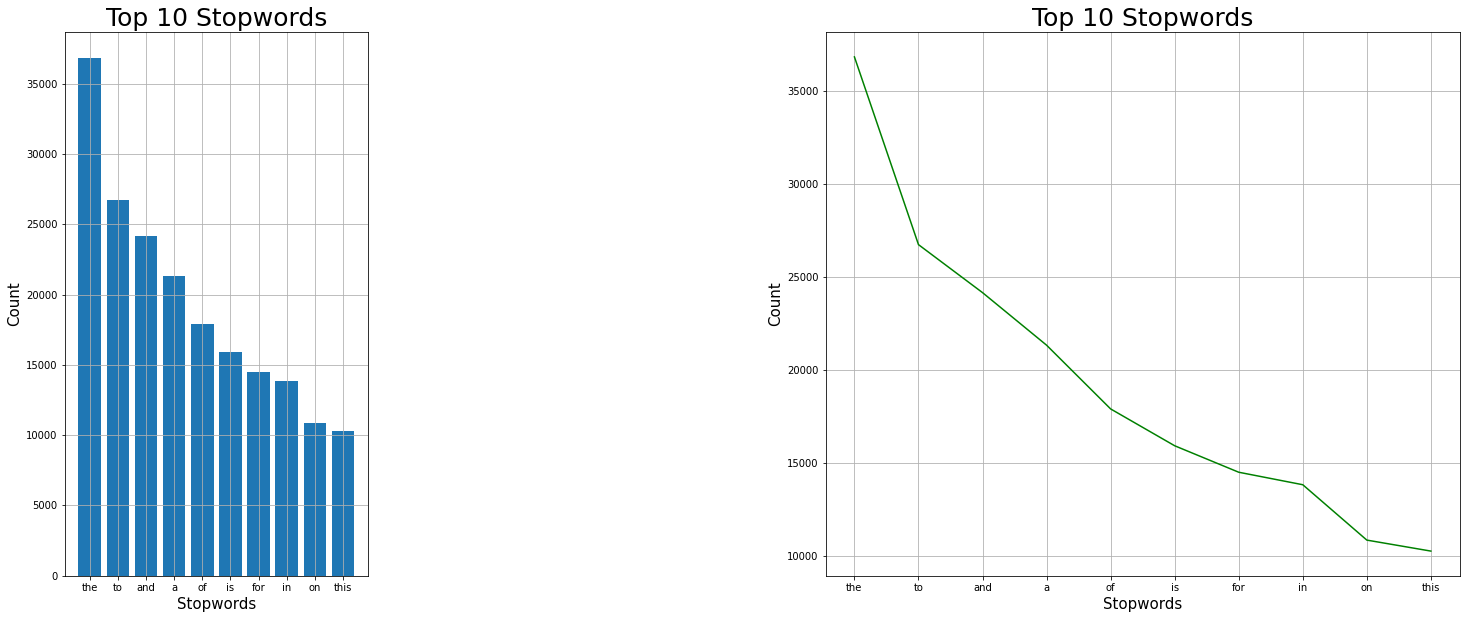

In [761]:
# Graphs for top 10 stopwords present in all the tweets
draw_bar_n_plot(top10,"Stopwords")

# Dealing with punctuations
Normally it is important to deal with punctions and remove punctions from the text so that the classifier works better. We use string library to fund punctuations.

In [762]:
# save list of punctuation/special characters in a variable
punctuation = list(string.punctuation)

In [763]:
# punctuations present in all the tweets 
pun = []
for message in data.Text:
    for word in message.split():
        if word in punctuation:
            pun.append(word)


# lets convert the list to a dictinoary which would contain the punctuations and their frequency
wordlist = nltk.FreqDist(pun)
# lets save the 10 most frequent stopwords
top10 = wordlist.most_common(10)

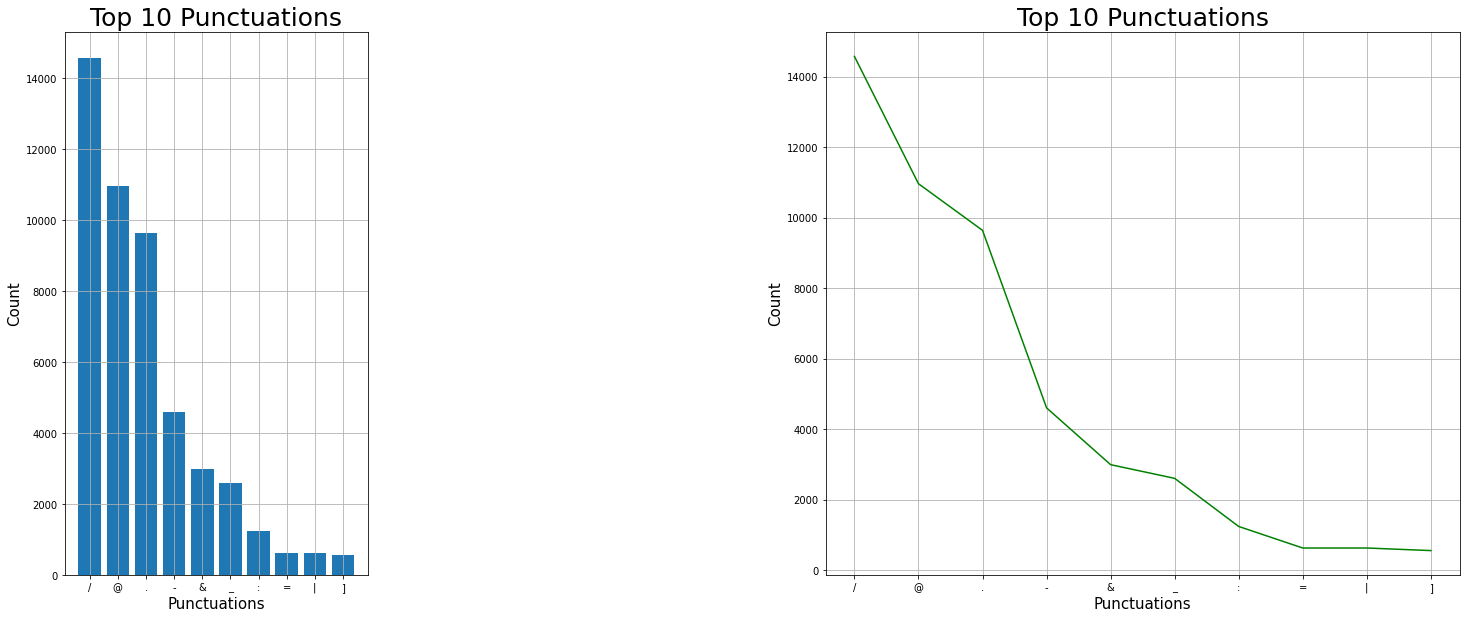

In [764]:
# draw graphs for top10 Punctuations
draw_bar_n_plot(top10,"Punctuations")

# Stopwords & Punctuations present in tweets' classes
Now it will be interesting to check what stopwords and punctuations are mostly used in the different classes. This is not possible to find out with the naked eyes, specially in very large datasets.

In [765]:
# Let's check stop words and punctuations in "Gaming platforms Tweets"
stop_positive = []
pun_positive  = []
for message in data[data.Target=='Positive']["Text"]:
    for word in message.split():
        if word in stop:
            stop_positive.append(word)
        if word in punctuation:
            pun_positive.append(word)


# lets convert the list to a dictinoary which would contain the stop word and its frequency
stop_positive_wordlist = nltk.FreqDist(stop_positive)
pun_positive_wordlist =  nltk.FreqDist(pun_positive)

# lets save the 10 most frequent stopwords
stop_positive_top10 = stop_positive_wordlist.most_common(10)
pun_positive_top10  = pun_positive_wordlist.most_common(10)

In [766]:
# Let's check stop words and punctuations in "Real Disaster Tweets"
stop_negative = []
pun_negative  = []
for message in data[data.Target=='Negative']["Text"]:
    for word in message.split():
        if word in stop:
            stop_negative.append(word)
        if word in punctuation:
            pun_negative.append(word)


# lets convert the list to a dictinoary which would contain the stop word and its frequency
stop_negative_wordlist = nltk.FreqDist(stop_negative)
pun_negative_wordlist =  nltk.FreqDist(pun_negative)

# lets save the 10 most frequent stopwords
stop_negative_top10 = stop_negative_wordlist.most_common(10)
pun_negative_top10  = pun_negative_wordlist.most_common(10)

In [767]:
# Let's check stop words and punctuations in "Real Disaster Tweets"
stop_neutral = []
pun_neutral  = []
for message in data[data.Target=='Neutral']["Text"]:
    for word in message.split():
        if word in stop:
            stop_neutral.append(word)
        if word in punctuation:
            pun_neutral.append(word)


# lets convert the list to a dictinoary which would contain the stop word and its frequency
stop_neutral_wordlist = nltk.FreqDist(stop_neutral)
pun_neutral_wordlist =  nltk.FreqDist(pun_neutral)

# lets save the 10 most frequent stopwords
stop_neutral_top10 = stop_neutral_wordlist.most_common(10)
pun_neutral_top10  = pun_neutral_wordlist.most_common(10)

In [768]:
# Let's check stop words and punctuations in "Real Disaster Tweets"
stop_irrelevant = []
pun_irrelevant  = []
for message in data[data.Target=='Irrelevant']["Text"]:
    for word in message.split():
        if word in stop:
            stop_irrelevant.append(word)
        if word in punctuation:
            pun_irrelevant.append(word)


# lets convert the list to a dictinoary which would contain the stop word and its frequency
stop_irrelevant_wordlist = nltk.FreqDist(stop_irrelevant)
pun_irrelevant_wordlist =  nltk.FreqDist(pun_irrelevant)

# lets save the 10 most frequent stopwords
stop_irrelevant_top10 = stop_irrelevant_wordlist.most_common(10)
pun_irrelevant_top10  = pun_irrelevant_wordlist.most_common(10)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


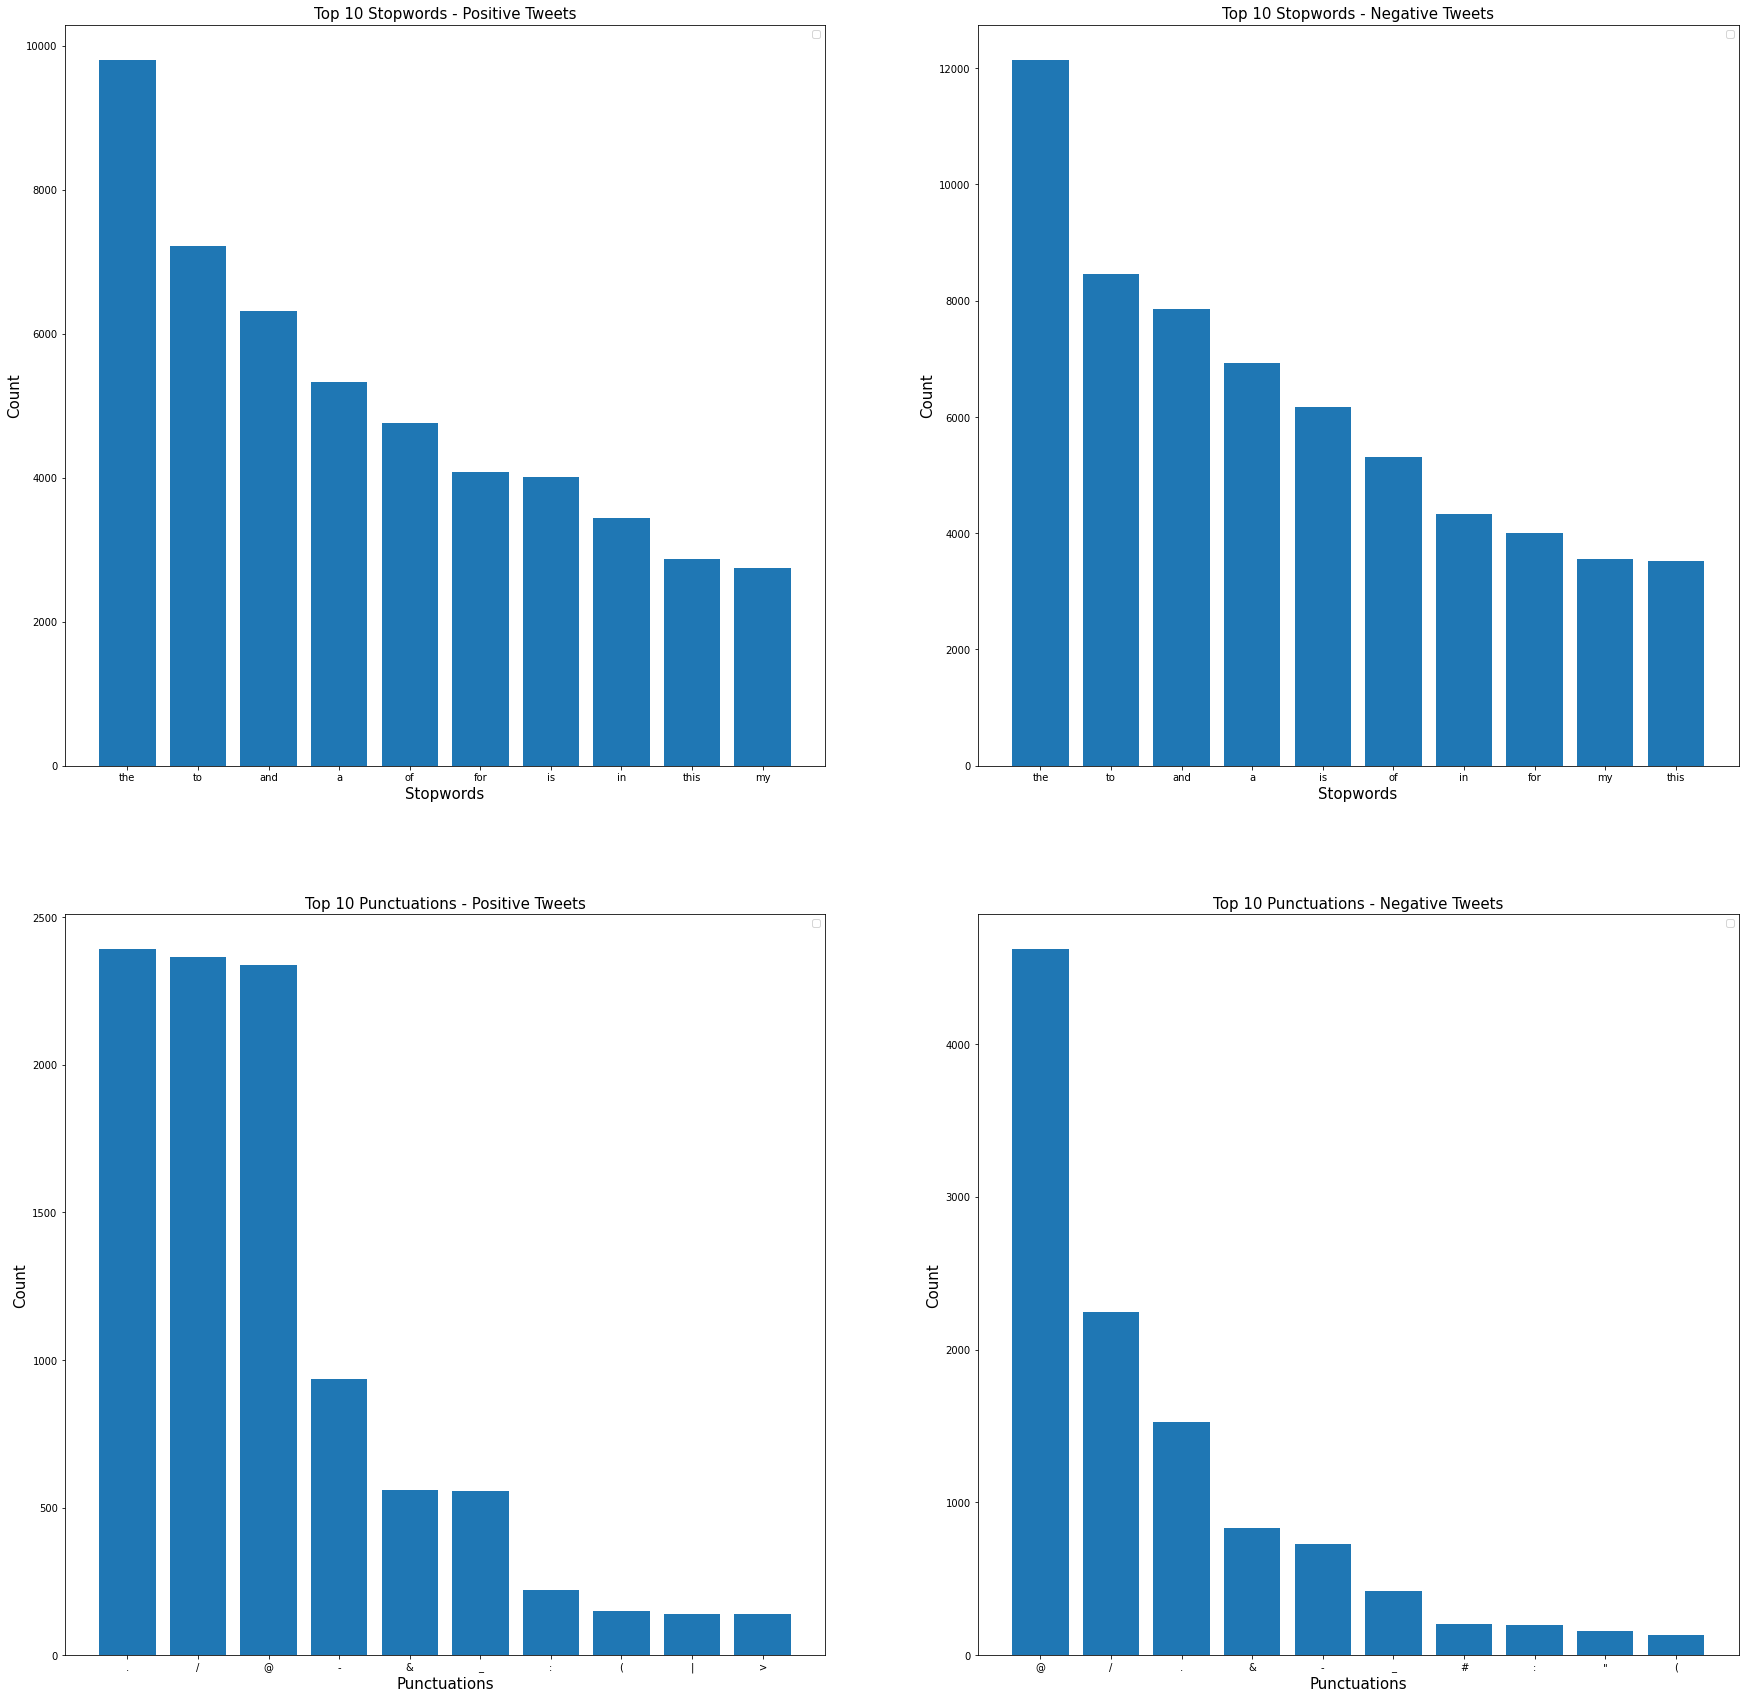

In [769]:
x_stop_positive,y_stop_positive=zip(*stop_positive_top10)
x_pun_positive, y_pun_positive =zip(*pun_positive_top10)

x_stop_negative,y_stop_negative=zip(*stop_negative_top10)
x_pun_negative, y_pun_negative=zip(*pun_negative_top10)


plt.figure(figsize = (30,30))
draw_bar_plot(x_stop_positive,y_stop_positive,"Stopwords","Count","Top 10 Stopwords - Positive Tweets",1)
draw_bar_plot(x_stop_negative,y_stop_negative,"Stopwords","Count","Top 10 Stopwords - Negative Tweets",2)
draw_bar_plot(x_pun_positive,y_pun_positive,"Punctuations","Count","Top 10 Punctuations - Positive Tweets",3)
draw_bar_plot(x_pun_negative,y_pun_negative,"Punctuations","Count","Top 10 Punctuations - Negative Tweets",4)

What we can see is that punctuations in negative classes are directed to someone, since @ is the most common by far. @ is often use to address a tweet to someone.

# Lemmatizer
This function will first tokenize the data, which means will create list of words from the sentences
To tackle punctuations we can use regular expressions, translation or simply use isalpha() function bearing in mind that space 
is eliminated with this function we will tokenize the text first, to note that if there is a massive dataset translate is the most efficient function
https://towardsdatascience.com/how-to-efficiently-remove-punctuations-from-a-string-899ad4a059fb
The next step will be to apply lemmatization,porter lemmatizer has been used in our case, for example words like coming,came,comes --> come

In [770]:
# create an object to convert the words to its lemma form
lemma = WordNetLemmatizer()

In [771]:
# lets make a combine list of stopwords and punctuations
sw_pun = stop + punctuation

# Regular expression to remove special characters and links 
Re library is being used to remove special characters and urls.

In [772]:
# function to preprocess the messages
def preprocess(tweet):
    tweet = re.sub(r"https?:\/\/t.co\/[A-Za-z0-9]+", "", tweet) # removing urls 
    tweet = re.sub('[^\w]',' ',tweet) # remove embedded special characters in words (for example #earthquake)         
    tweet = re.sub('[\d]','',tweet) # this will remove numeric characters
    tweet = tweet.lower()
    words = tweet.split()  
    sentence = ""
    for word in words:     
        if word not in (sw_pun):  # removing stopwords & punctuations                
            word = lemma.lemmatize(word,pos = 'v')  # converting to lemma    
            if len(word) > 3: # we will consider words with length  greater than 3 only
                sentence = sentence + word + ' '             
    return(sentence)

In [773]:
def cleaner(tweet):
    tweet = re.sub(r"https?:\/\/t.co\/[A-Za-z0-9]+", "", tweet) # removing urls 
    tweet = re.sub('[^\w]',' ',tweet) # remove embedded special characters in words (for example #earthquake)         
    tweet = re.sub('[\d]','',tweet) # this will remove numeric characters
    tweet = tweet.lower()
    sentence = ""
    # Tokens
    tokens = word_tokenize(str(tweet).replace("'", "").lower()) 
    
    # Remove Puncs
    without_punc = [w for w in tokens if w not in punctuation]
    
    # Stopwords
    without_sw = [t for t in without_punc if t not in stop]
    
    # Lemmatize
    text_len = [WordNetLemmatizer().lemmatize(t) for t in without_sw]
    # Stem
    text_cleaned = [PorterStemmer().stem(w) for w in text_len]
    
    return " ".join(text_cleaned)

In [774]:
# apply preprocessing functions on the train and test datasets
data['Text'] = data['Text'].apply(lambda s : cleaner(s))
val ['Text'] = val ['Text'].apply(lambda s : cleaner(s))

In [775]:
data.head()

,Text,Target,Sentiment
0,im get borderland murder,Positive,1
1,come border kill,Positive,1
2,im get borderland kill,Positive,1
3,im come borderland murder,Positive,1
4,im get borderland murder,Positive,1


In [776]:
#replaced I'm as occurs several times
data["Text"]=data["Text"].str.replace("im","")
data["Text"].head()

0      get borderland murder
1           come border kill
2        get borderland kill
3     come borderland murder
4      get borderland murder
Name: Text, dtype: object

# Rare Words
We will remove rare words from the dataset as rare words rarely offer interesting insights and will not really score high.

In [777]:
rare_words = pd.Series(" ".join(data["Text"]).split()).value_counts()
rare_words

game            10996
com              9572
play             6901
get              5581
like             5174
                ...  
arbitr              1
bandmat             1
ftyztvlv            1
fenghtesport        1
beckett             1
Length: 22622, dtype: int64

In [778]:
rare_words = rare_words[rare_words <= 2]

In [779]:
data["Text"] = data["Text"].apply(lambda x: " ".join([i for i in x.split() if i not in rare_words.index]))
val["Text"] = val["Text"].apply(lambda x: " ".join([i for i in x.split() if i not in rare_words.index]))

In [780]:
# function to create vocab
from collections import Counter
def create_vocab(df):
    vocab = Counter()
    for i in range(df.shape[0]):
        vocab.update(df.Text[i].split())
    return(vocab)


# Vocabulary
The next step will be to investigate the vocabulary used in this data set. The most common vocabulary will be investigated in the gaming tweets world. We will keep vocabulary that occurs only more than once.

In [781]:
# concatenate training and testing datasets
master=pd.concat((data,val)).reset_index(drop=True)

# call vocabulary creation function on master dataset
vocab = create_vocab(master)

# lets check the no. of words in the vocabulary
len(vocab)

17177

In [782]:
# lets check the most common 50 words in the vocabulary
vocab.most_common(50)

[('game', 11171),
 ('com', 9844),
 ('play', 7005),
 ('get', 5677),
 ('like', 5259),
 ('go', 4330),
 ('fuck', 4240),
 ('pic', 3991),
 ('twitter', 3910),
 ('love', 3828),
 ('one', 3767),
 ('good', 3564),
 ('new', 3286),
 ('realli', 3254),
 ('te', 3247),
 ('u', 3185),
 ('see', 3130),
 ('johnson', 3069),
 ('unk', 2956),
 ('make', 2948),
 ('look', 2948),
 ('thank', 2822),
 ('shit', 2787),
 ('peopl', 2772),
 ('player', 2666),
 ('best', 2570),
 ('got', 2556),
 ('facebook', 2465),
 ('still', 2452),
 ('year', 2416),
 ('p', 2402),
 ('day', 2347),
 ('even', 2330),
 ('amazon', 2317),
 ('work', 2273),
 ('great', 2258),
 ('xbox', 2209),
 ('googl', 2144),
 ('ban', 2143),
 ('want', 2104),
 ('pleas', 2081),
 ('microsoft', 2072),
 ('call', 2028),
 ('rhandlerr', 2016),
 ('know', 2006),
 ('dead', 2002),
 ('verizon', 1981),
 ('back', 1950),
 ('say', 1900),
 ('much', 1872)]

In [783]:
# create the final vocab by considering words with more than one occurence
final_vocab = []
min_occur = 2
for k,v in vocab.items():
    if v >= min_occur:
        final_vocab.append(k)

In [784]:
# lets check the no. of the words in the final vocabulary
len(final_vocab)

16744

In [785]:
# function to filter the dataset, keep only words which are present in the vocab
def filter(tweet):
    sentence = ""
    for word in tweet.split():  
        if word in final_vocab:
            sentence = sentence + word + ' '
    return(sentence)

In [786]:
# apply filter function on the train and test datasets
data['Text'] = data['Text'].apply(lambda s : filter(s))
val ['Text'] = val ['Text'].apply(lambda s : filter(s))

# Cleaning some special characters

In [787]:
## We can further see that there are still some special characters in the dataframe which have to be treated.
data.replace('\d+', '', regex=True, inplace=True)
data.replace(',', '', regex=True, inplace=True)
data.replace('br', '', regex=True, inplace=True)
data.replace('"', '', regex=True, inplace=True)
data.replace("'", '', regex=True, inplace=True)
data.replace('?', '', inplace=True)
data.replace("-", '', regex=True, inplace=True)
data.replace("*", '', inplace=True)
data.replace("***", '', inplace=True)
data.replace("< />", '', regex=True, inplace=True)

In [788]:
## Using the strip function in order to delete the special characters.
data['Text'] = data['Text'].str.strip('[')
data['Text'] = data['Text'].str.strip(']')
data['Text'] = data['Text'].str.strip(')')
data['Text'] = data['Text'].str.strip('(')


In [789]:
#checking last 5 rows of dataset
data.tail()

,Text,Target,Sentiment
74677,realiz window partit mac like year behind nvid...,Positive,1
74678,realiz mac window partit year behind nvidia dr...,Positive,1
74679,realiz window partit mac year behind nvidia dr...,Positive,1
74680,realiz window partit mac like year behind nvid...,Positive,1
74681,like window partit mac like year behind driver...,Positive,1


In [790]:
val.tail()

,Text,Target
995,toronto art cultur capit canada wonder want st...,Neutral/Irrelevant
996,actual good move tot bring viewer one peopl go...,Neutral/Irrelevant
997,today suck time drink wine n play borderland s...,Positive
998,bought fraction microsoft today small win,Positive
999,johnson johnson stop sell talc babi powder u c...,Neutral/Irrelevant


In [791]:
# lets create seperate datasets from real and fake tweets
positive = data[data.Sentiment==1].reset_index()
negative = data[data.Sentiment==-1].reset_index()
neutral_irrelevant = data[data.Sentiment==0].reset_index()

In [792]:
# function to create top 100 n-grams
def get_ngrams(data,n):
    all_words = []
    for i in range(len(data)):
        temp = data["Text"][i].split()
        for word in temp:
            all_words.append(word)

    tokenized = all_words
    esBigrams = ngrams(tokenized, n)

    esBigram_wordlist = nltk.FreqDist(esBigrams)
    top100 = esBigram_wordlist.most_common(100)
    top100 = dict(top100)
    df_ngrams = pd.DataFrame(sorted(top100.items(), key=lambda x: x[1])[::-1])
    return df_ngrams

In [793]:
# function to visualize the top 100 n-grams in positive and negative tweets
def draw_barplots(real,fake,title):
    plt.figure(figsize = (40,80),dpi=100)

    plt.subplot(1,2,1)
    sns.barplot(y=real[0].values[:100], x=real[1].values[:100], color='green')
    plt.title("Top 100" + title + "in Positive Tweets",fontsize=15)
    
    plt.subplot(1,2,2)
    sns.barplot(y=fake[0].values[:100], x=fake[1].values[:100],color='red')
    plt.title("Top 100" + title + "in Negative Tweets",fontsize=15)

# Unigram
We are going to look at unigram that is single word occurence. Game is common in both positive and negative tweets.

In [794]:
# lets create top 100 unigrams
positive_unigrams = get_ngrams(positive,1)
negative_unigrams = get_ngrams(negative,1)
neutral_irrelevant_unigrams = get_ngrams(neutral_irrelevant,1)

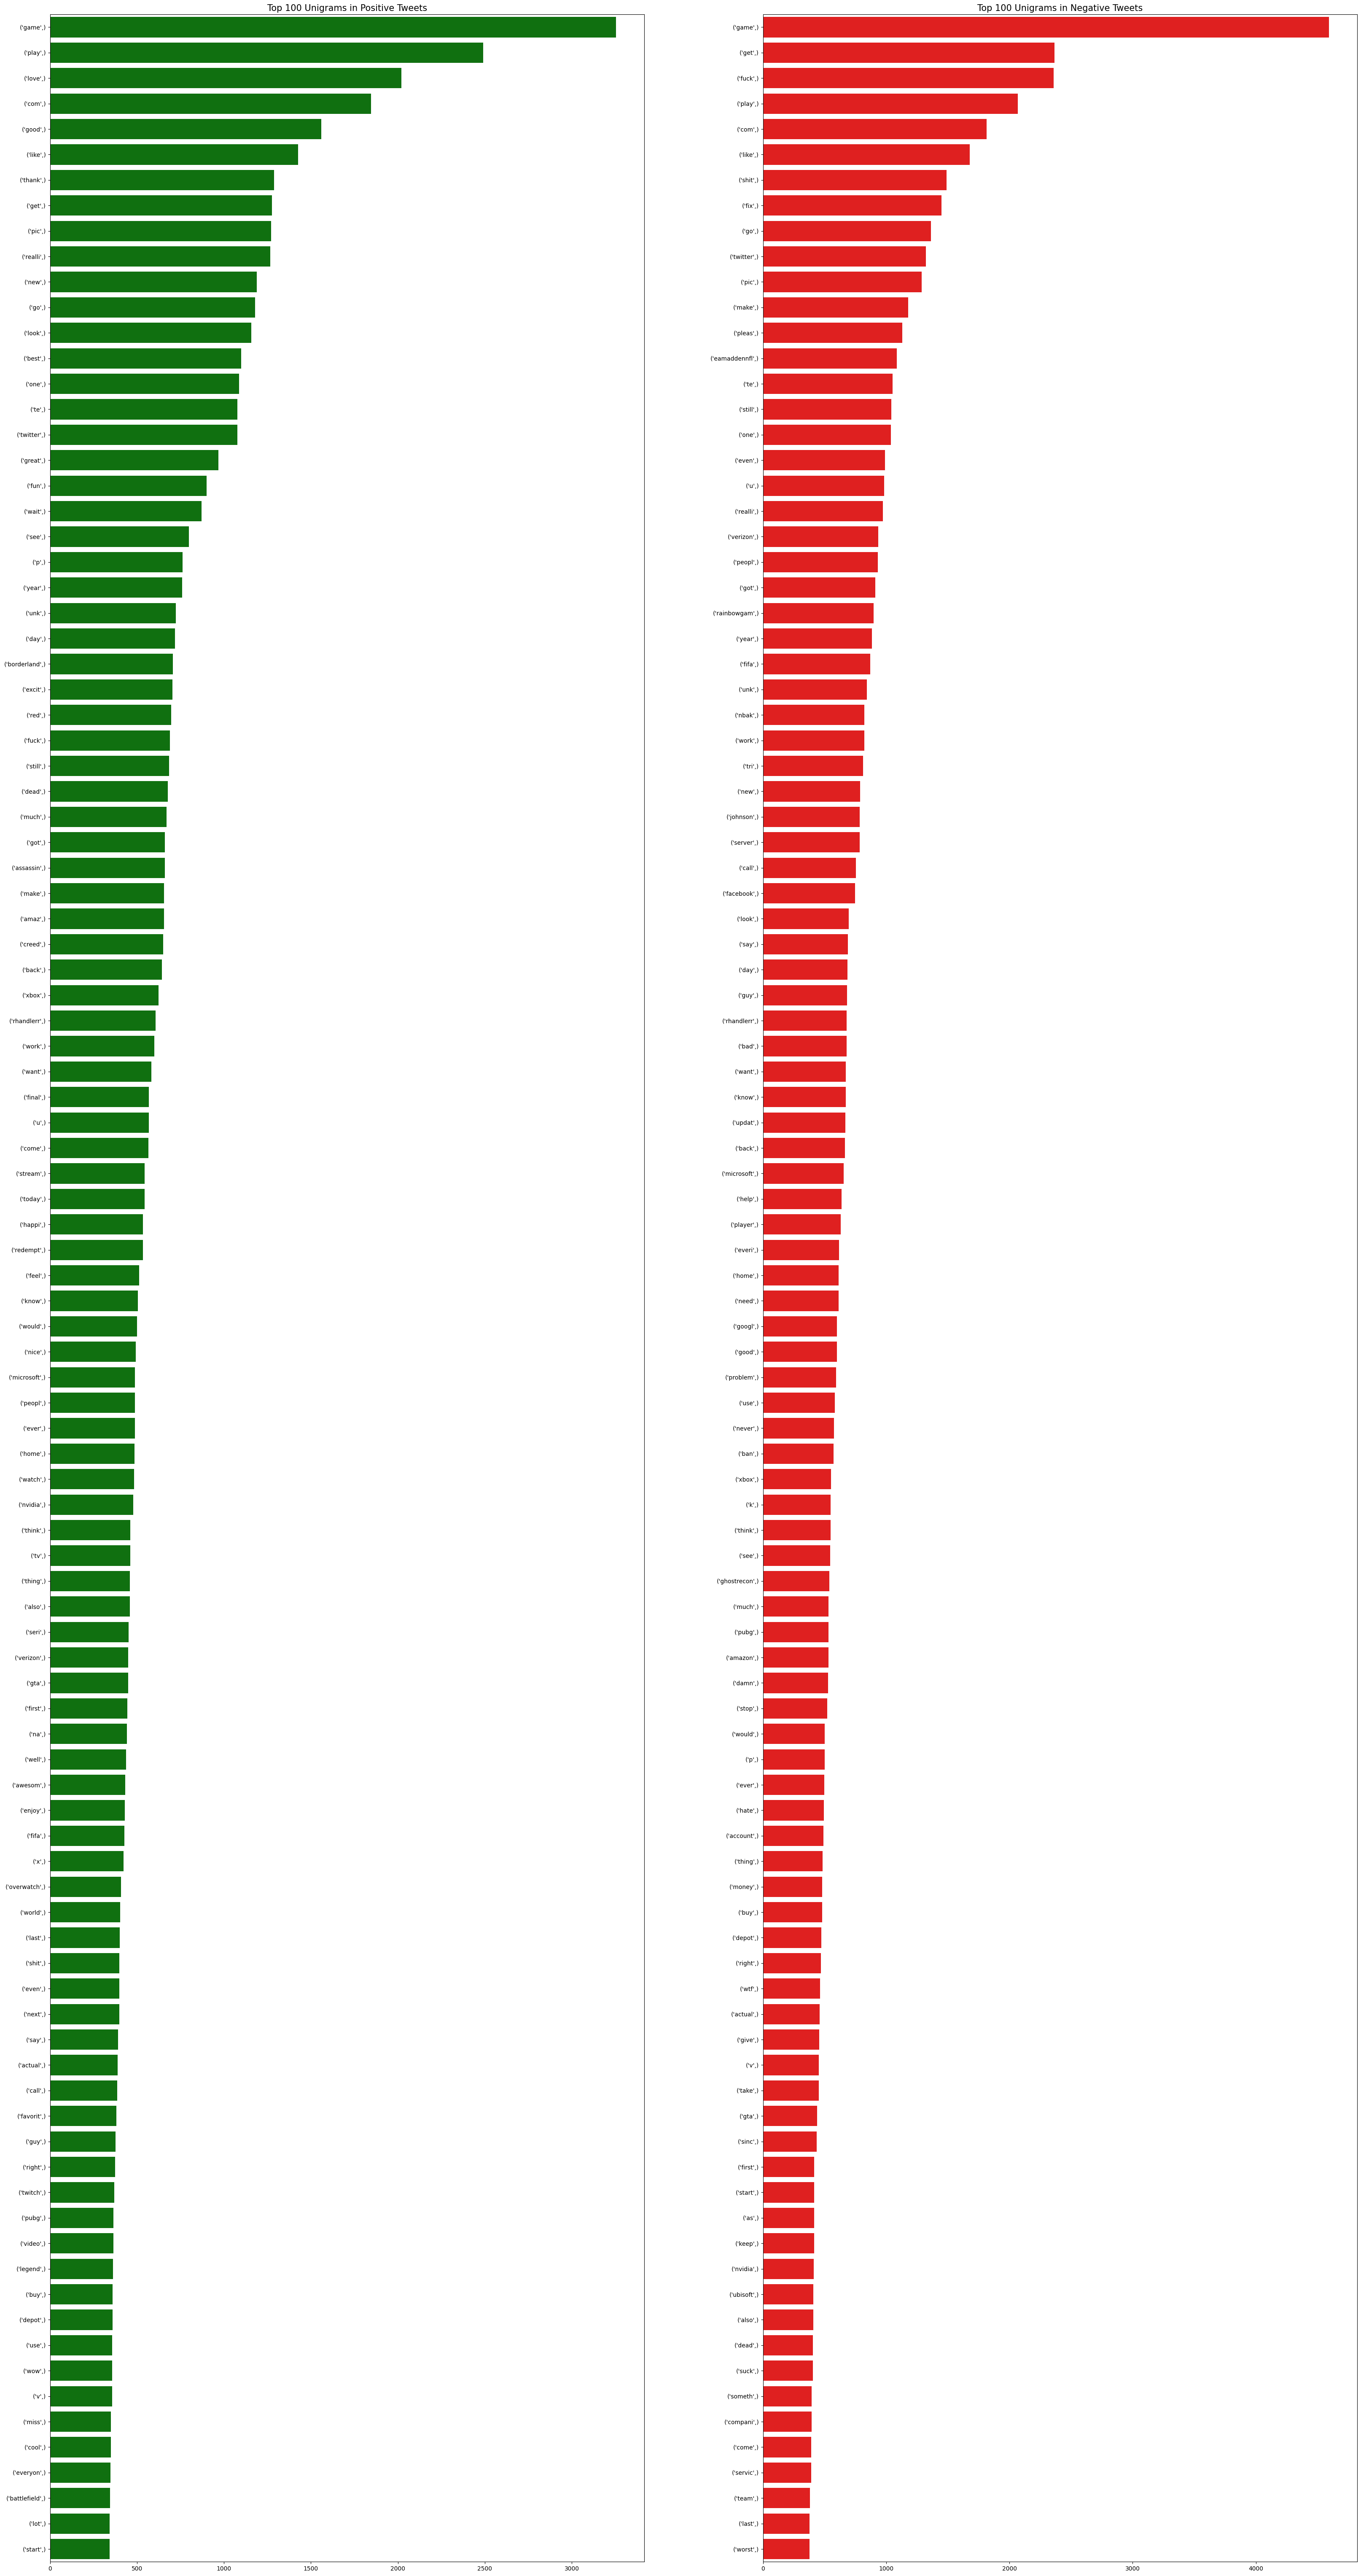

In [795]:
# lets visualize top 100 unigrams
draw_barplots(positive_unigrams,negative_unigrams," Unigrams ")

# Bigrams
Bigrams shows us the two common words that occurs one after another very often.

In [796]:
# lets create top 100 bigrams
positive_bigrams = get_ngrams(positive,2)
negative_bigrams = get_ngrams(negative,2)

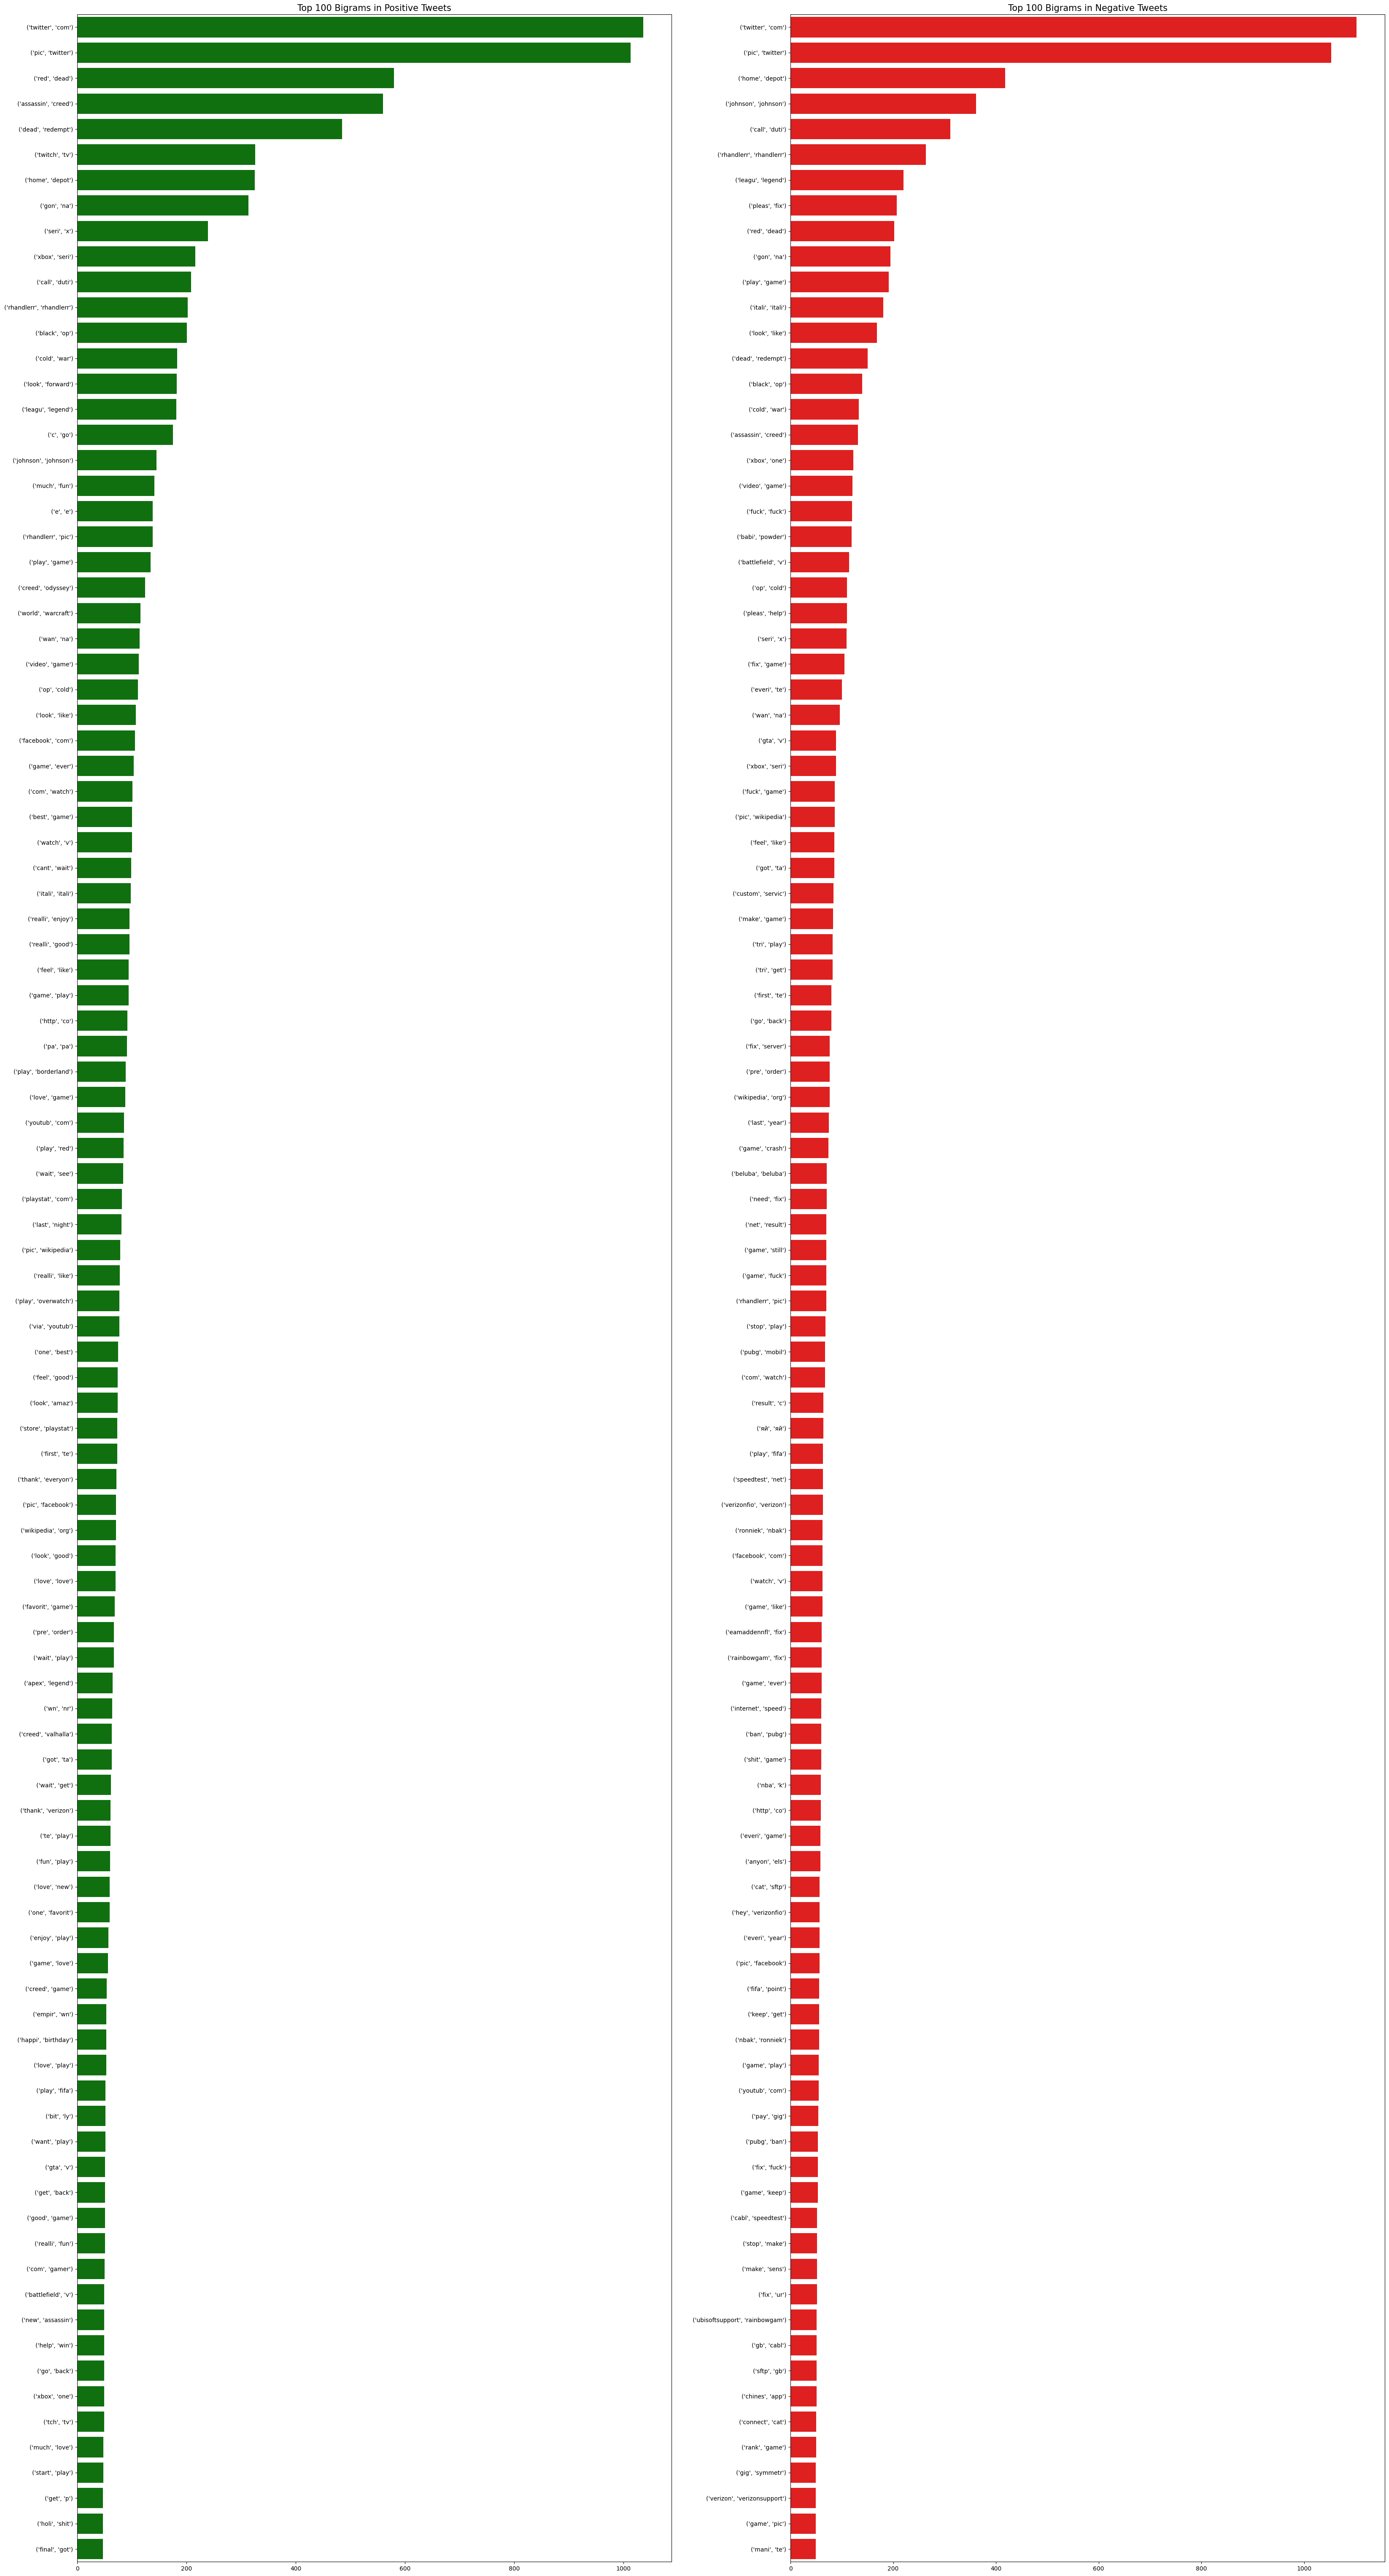

In [797]:
# lets visualize top 100 bigrams
draw_barplots(positive_bigrams,negative_bigrams," Bigrams ")

# Trigrams
Shows us three consecutive words occurence, that takes place often

In [798]:
# lets create top 100 trigrams
positive_trigrams = get_ngrams(positive,3)
negative_trigrams = get_ngrams(negative,3)

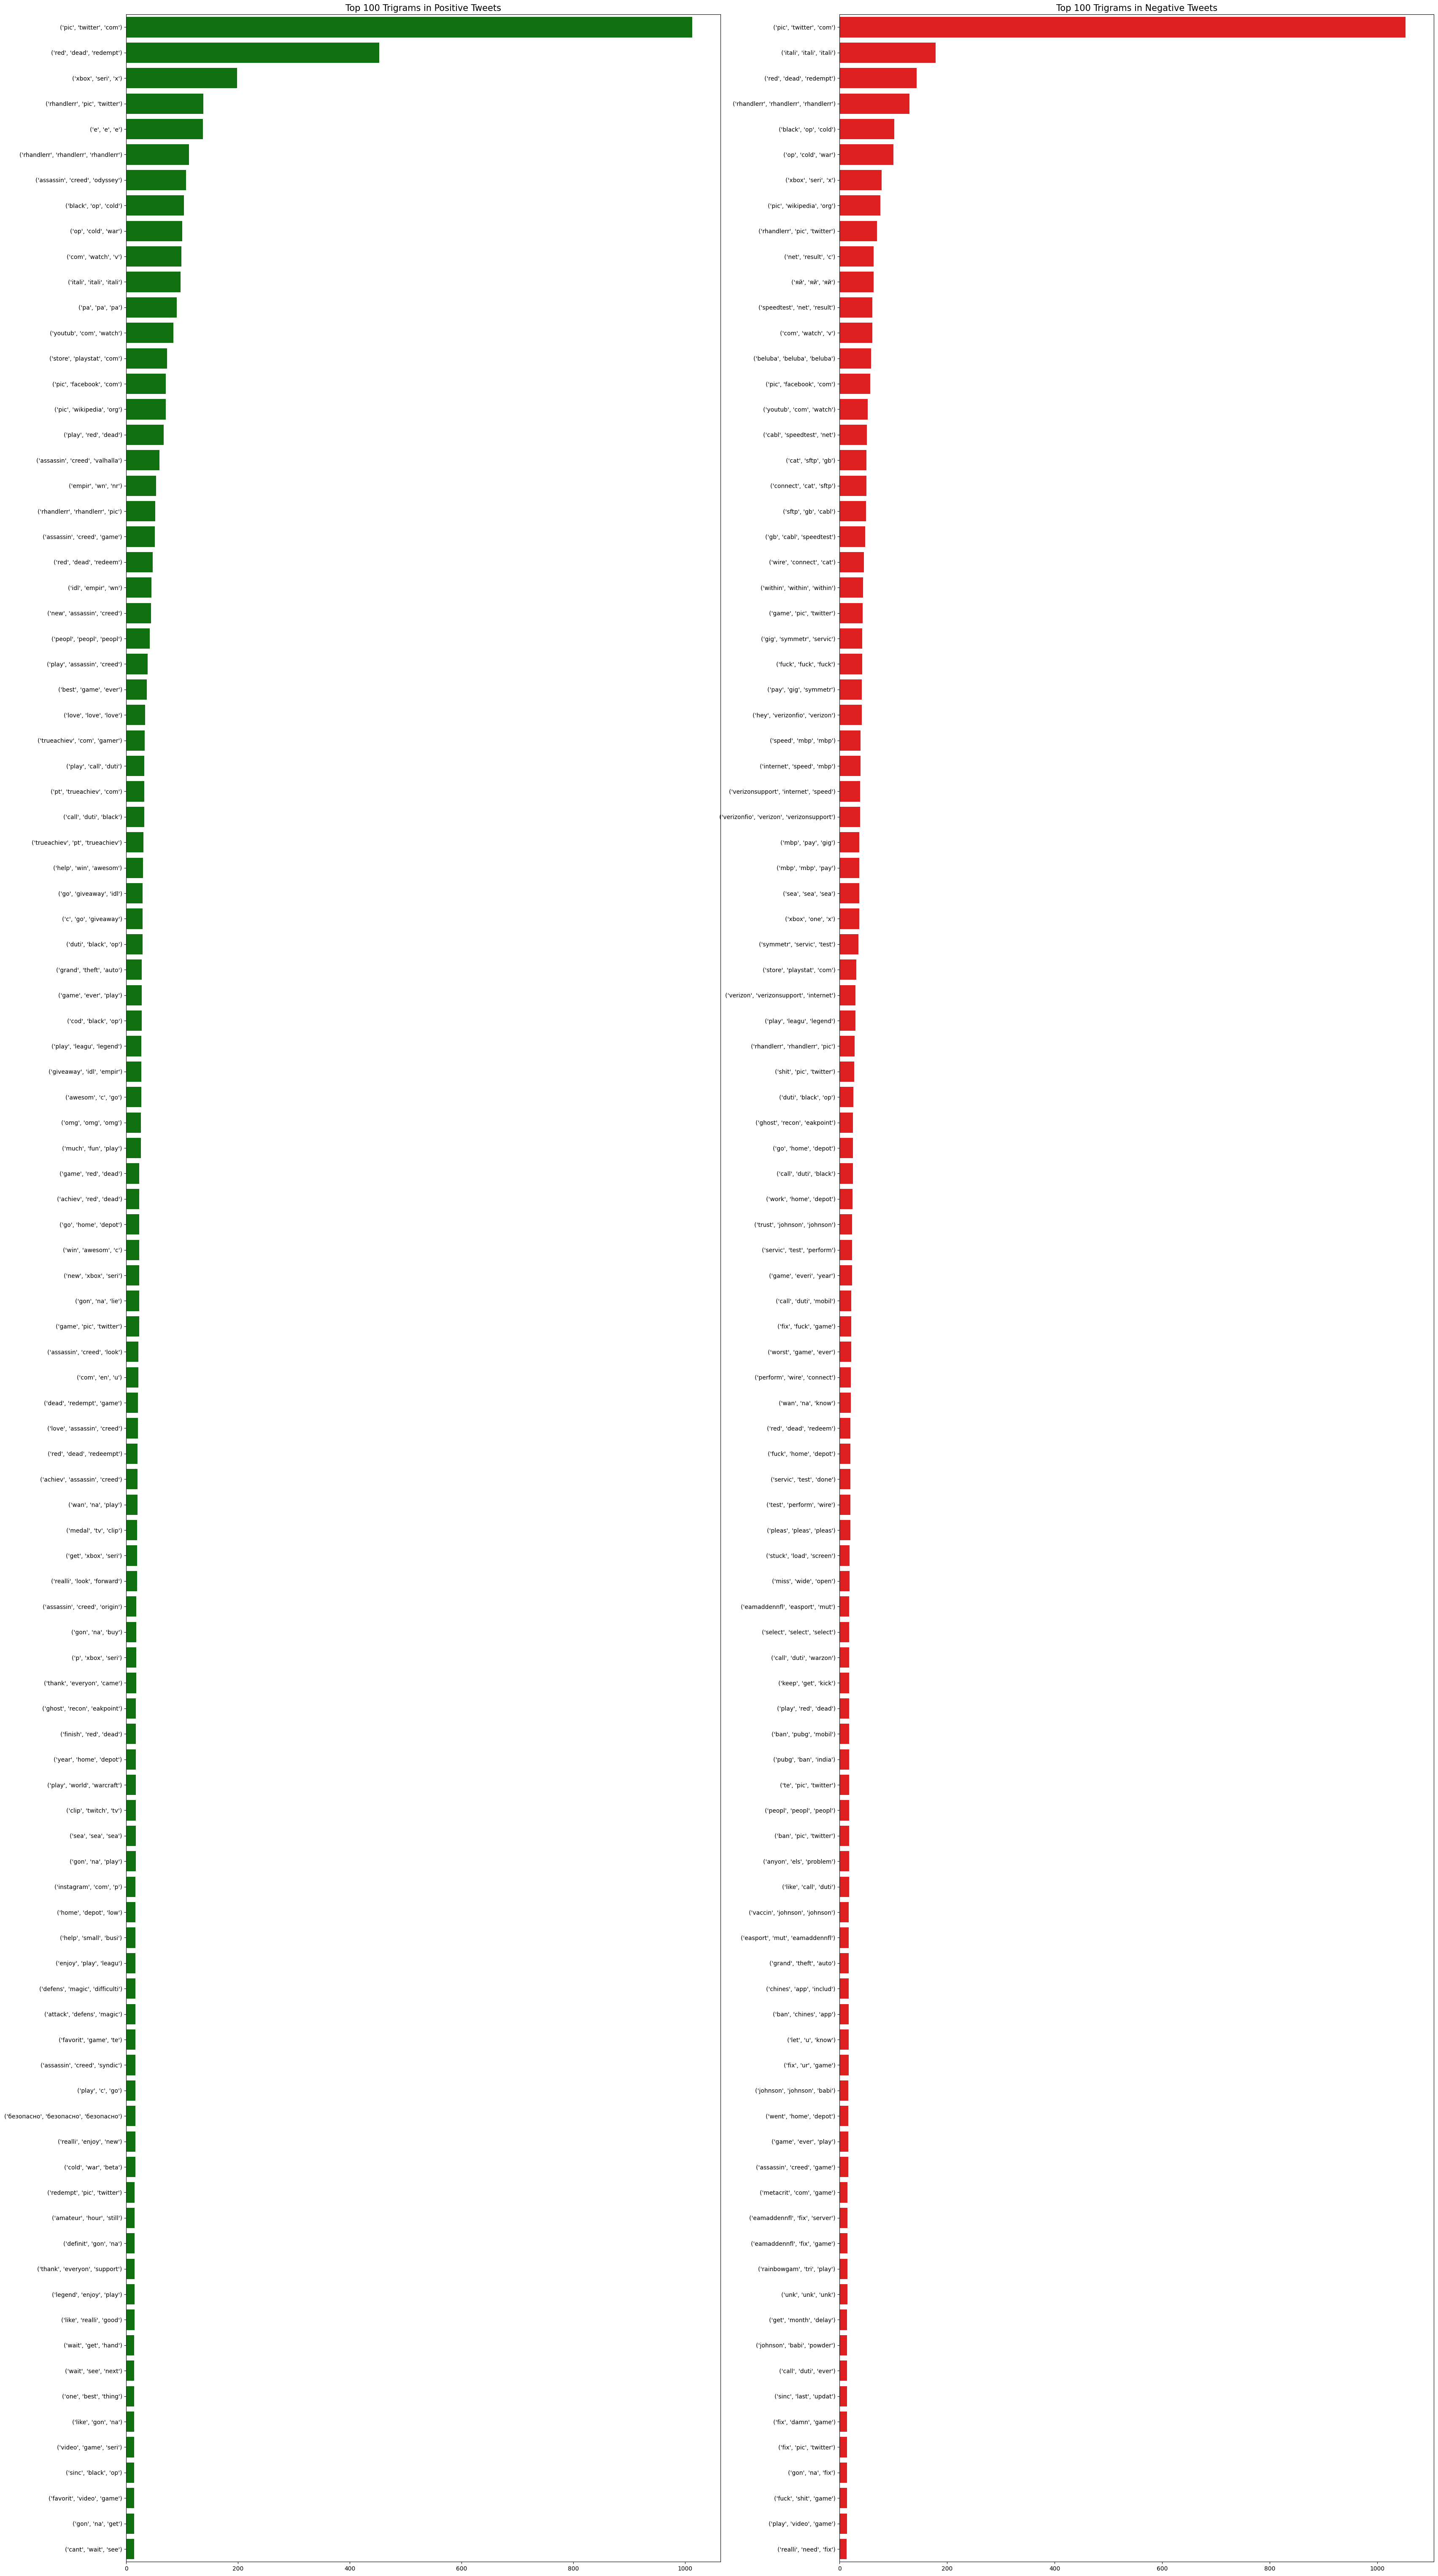

In [799]:
# lets visualize top 100 trigrams
draw_barplots(positive_trigrams,negative_trigrams," Trigrams ")

In [800]:
data.Target.count()

69769

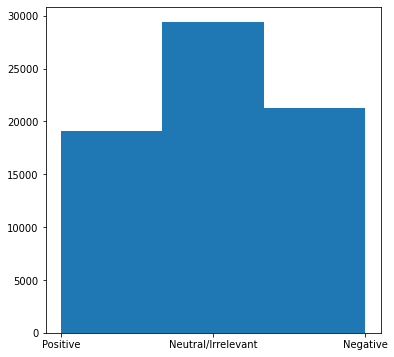

In [801]:
#check class imbalance
plt.hist(data.Target,bins=3)
plt.show()

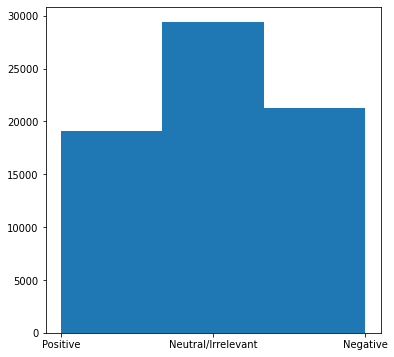

In [802]:
#data = data.drop(data[data['Sentiment'] ==0].sample(frac=.3).index)
#check class imbalance
plt.hist(data.Target,bins=3)
plt.show()

In [803]:
#splitting the data
X = data["Text"]
y = data["Sentiment"]

# Train Test Split

In [804]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score,precision_recall_curve
from sklearn.naive_bayes import MultinomialNB, BernoulliNB 
from sklearn.ensemble import RandomForestClassifier

In [805]:
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size = 0.30,random_state= 42)

## Count Vectorizer

In [806]:
from sklearn.feature_extraction.text import CountVectorizer

In [807]:
vt = CountVectorizer(analyzer="word")
X_train_count = vt.fit_transform(X_train)
X_test_count = vt.transform(X_test)

In [808]:
print(X_train_count.toarray())
X_train_count

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


<48838x16547 sparse matrix of type '<class 'numpy.int64'>'
	with 509046 stored elements in Compressed Sparse Row format>

#  Decision Tree Classifier

In [809]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier()
dtc.fit(X_train_count,y_train)
dtc_pred = dtc.predict(X_test_count)
dtc_train_pred = dtc.predict(X_train_count)

In [810]:
# Classification Report
cr = classification_report(y_test,dtc_pred)
print(cr)

              precision    recall  f1-score   support

          -1       0.85      0.85      0.85      6364
           0       0.86      0.85      0.86      8907
           1       0.81      0.82      0.82      5660

    accuracy                           0.84     20931
   macro avg       0.84      0.84      0.84     20931
weighted avg       0.84      0.84      0.84     20931



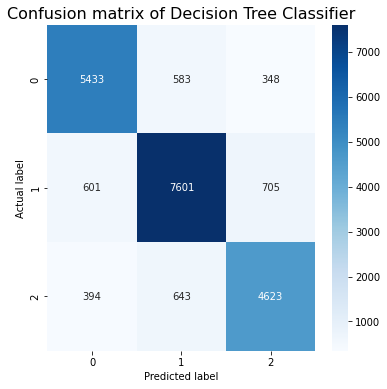

In [811]:
# Confusion Matrix
cm = confusion_matrix(y_test, dtc_pred)
plt.rcParams['figure.figsize'] = (6, 6)
sns.heatmap(cm, annot = True, cmap = 'Blues', fmt = '.8g')
plt.title('Confusion matrix of Decision Tree Classifier', fontsize = 16)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

In [812]:
viz = PrecisionRecallCurve(dtc,classes=dtc.classes_,per_class=True,cmap="Set1")
viz.fit(X_train_count,y_train)
viz.score(X_test_count, y_test)
viz.show();

NameError: name 'PrecisionRecallCurve' is not defined

In [ ]:
viz = ROCAUC(dtc, classes=dtc.classes_, per_class=True,map="Set1")
viz.fit(X_train_count,y_train)
viz.score(X_test_count, y_test)
viz.show();

In [813]:
#will keep only relevant features that will be used by the classifier
data = data[["Text","Target"]]
val = val[["Text","Target"]]

In [814]:
classes = set(data.Target)
print(classes)

{'Negative', 'Positive', 'Neutral/Irrelevant'}


In [815]:
class_to_index = dict((c,i) for i, c in enumerate(classes))
index_to_class = dict((v,k) for k,v in class_to_index.items())

In [816]:
class_to_index

{'Negative': 0, 'Positive': 1, 'Neutral/Irrelevant': 2}

In [817]:
index_to_class

{0: 'Negative', 1: 'Positive', 2: 'Neutral/Irrelevant'}

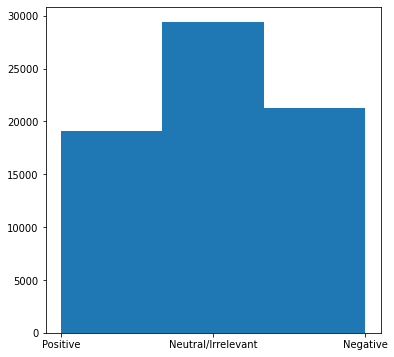

In [818]:
plt.hist(data.Target,bins=3)
plt.show()

In [819]:
train,test = train_test_split(data,test_size=.2,shuffle=False)


In [820]:
train

,Text,Target
0,get borderland murder,Positive
1,come border kill,Positive
2,get borderland kill,Positive
3,come borderland murder,Positive
4,get borderland murder,Positive
...,...,...
59801,facebook jail say nothin even tell nobodi got ...,Neutral/Irrelevant
59802,tri search cheap ttrpg shit facebook marketpla...,Neutral/Irrelevant
59803,tri search facebook marketplac cheap ttrpg shi...,Neutral/Irrelevant
59804,tri search cheap ttrpg shit facebook marketpla...,Neutral/Irrelevant


In [821]:
test

,Text,Target
59806,tri desper spli search frantic cheap ttrpg pri...,Neutral/Irrelevant
59807,tri search cheap ttrpg shit facebook page hear...,Neutral/Irrelevant
59808,dmmuzaffarnagar magistrate_c muzafarnagarpol p...,Neutral/Irrelevant
59809,dmmuzaffarnagar magistr citi muzafarnagarpol p...,Neutral/Irrelevant
59810,dmmuzaffarnagar magistr citi muzafarnagarpol m...,Neutral/Irrelevant
...,...,...
74677,realiz window partit mac like year behind nvid...,Positive
74678,realiz mac window partit year behind nvidia dr...,Positive
74679,realiz window partit mac year behind nvidia dr...,Positive
74680,realiz window partit mac like year behind nvid...,Positive


In [822]:
test = test.reset_index()

In [823]:
test

,index,Text,Target
0,59806,tri desper spli search frantic cheap ttrpg pri...,Neutral/Irrelevant
1,59807,tri search cheap ttrpg shit facebook page hear...,Neutral/Irrelevant
2,59808,dmmuzaffarnagar magistrate_c muzafarnagarpol p...,Neutral/Irrelevant
3,59809,dmmuzaffarnagar magistr citi muzafarnagarpol p...,Neutral/Irrelevant
4,59810,dmmuzaffarnagar magistr citi muzafarnagarpol m...,Neutral/Irrelevant
...,...,...,...
13949,74677,realiz window partit mac like year behind nvid...,Positive
13950,74678,realiz mac window partit year behind nvidia dr...,Positive
13951,74679,realiz window partit mac year behind nvidia dr...,Positive
13952,74680,realiz window partit mac like year behind nvid...,Positive


In [824]:
# Bag of Words model
##from keras.preprocessing.text import Tokenizer

# fit a tokenizer
##def create_tokenizer(lines):
  ##  tokenizer = Tokenizer()
  ##  tokenizer.fit_on_texts(lines)
  ##  return tokenizer

In [825]:
# lets use only tweet text to build the model
#X = train.Text
#y = train.Target

In [826]:
# Test train split 
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [827]:
# create and apply tokenizer on the training dataset
#tokenizer = create_tokenizer(X_train)
#X_train_set = tokenizer.texts_to_matrix(X_train, mode = 'freq')

In [828]:
#y_train[1],X_train[1]

In [829]:
#X_train_set

In [830]:
# define the model
#def define_model(n_words):
    # define network
 ##   model = Sequential()
  ##  model.add(Dense(128, input_shape=(n_words,), activation='relu'))
  ##  model.add(Dense(1, activation='sigmoid'))
    # compile network
  ##  model.compile(loss='binary_crossentropy', optimizer='adam', metrics = 'accuracy')
    # summarize defined model
   ## model.summary()
   ## plot_model(model, to_file='model.png', show_shapes=True)
   ## return model

In [831]:
# create the model
##n_words = X_train_set.shape[1]
##model = define_model(n_words)

In [832]:
#fit network
##model.fit(X_train_set,y_train,batch_size=50,epochs=50,verbose=2)

In [833]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [834]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [835]:
tokenizer = Tokenizer(num_words=10000, oov_token='<UNK')#tokenize 10000 different words
tokenizer.fit_on_texts(train.Text)

In [836]:
tokenizer.texts_to_sequences([train.Text[34]])

[[257,
  56,
  102,
  578,
  18,
  114,
  634,
  114,
  65,
  61,
  24,
  82,
  370,
  387,
  24,
  2064,
  82,
  1,
  94,
  2244,
  16,
  18,
  55,
  704,
  1,
  1,
  1,
  1]]

In [837]:
train.Text[1],train.Target[1]

('come border kill ', 'Positive')

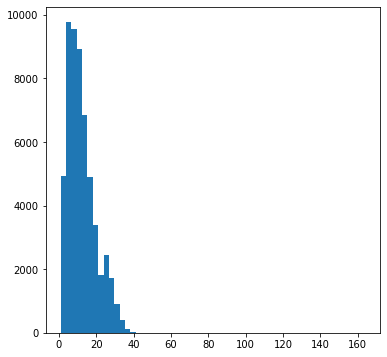

In [838]:
lengths = [len(t.split(' ')) for t in train.Text]
plt.hist(lengths,bins=len(set(lengths)))
plt.show()

In [839]:
#any tweet more than 40 words will be chopped
maxlen=40

In [840]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [841]:
#all example will have same input size
def get_sequences(tokenizer,tweets):
  sequences = tokenizer.texts_to_sequences(tweets)
  padded = pad_sequences(sequences, truncating='post',padding='post',maxlen=maxlen)
  return padded

In [842]:
padded_train_seq = get_sequences(tokenizer, train.Text)

In [843]:
padded_train_seq[10]

array([ 732,  157,   24,  143,   65,   54,  330,   44,  216, 2531,   12,
        183,  269,  602,   24,    1,  188,  381,  992, 3609, 6199,  127,
        149,    9,   11,    3,    1,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0])

In [844]:
model = tf.keras.models.Sequential([
        tf.keras.layers.Embedding(10000,16, input_length=maxlen),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)), #output at every timestep
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
        tf.keras.layers.Dense(6, activation='softmax')                                                     
        ])
        
model.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = 'adam',
    metrics=['accuracy']
)

In [845]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 40, 16)            160000    
                                                                 
 bidirectional_6 (Bidirectio  (None, 40, 40)           5920      
 nal)                                                            
                                                                 
 bidirectional_7 (Bidirectio  (None, 40)               9760      
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 6)                 246       
                                                                 
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


In [846]:
names_to_ids = lambda labels: np.array([class_to_index.get(x) for x in labels])

In [847]:
val_seq = get_sequences(tokenizer,val.Text)
val_labels = names_to_ids(val.Target)

In [848]:
train_labels = names_to_ids(train.Target)
print(train_labels[0])

1


In [849]:
h = model.fit(
    padded_train_seq,train_labels ,
    validation_data = (val_seq,val_labels),
    epochs = 25,
    callbacks = [
                 tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=5)#if model does not see improvement in accuracy over 2 epochs it will stop
    ]
)

Epoch 1/25
1745/1745 [==============================] - 26s 13ms/step - loss: 0.7502 - accuracy: 0.6643 - val_loss: 0.5297 - val_accuracy: 0.7998
Epoch 2/25
1745/1745 [==============================] - 20s 11ms/step - loss: 0.4345 - accuracy: 0.8319 - val_loss: 0.4943 - val_accuracy: 0.8308
Epoch 3/25
1745/1745 [==============================] - 20s 12ms/step - loss: 0.3349 - accuracy: 0.8715 - val_loss: 0.5183 - val_accuracy: 0.8328
Epoch 4/25
1745/1745 [==============================] - 25s 14ms/step - loss: 0.2679 - accuracy: 0.8955 - val_loss: 0.5398 - val_accuracy: 0.8559
Epoch 5/25
1745/1745 [==============================] - 24s 14ms/step - loss: 0.2240 - accuracy: 0.9128 - val_loss: 0.5728 - val_accuracy: 0.8488
Epoch 6/25
1745/1745 [==============================] - 25s 14ms/step - loss: 0.1948 - accuracy: 0.9236 - val_loss: 0.6123 - val_accuracy: 0.8559
Epoch 7/25
1745/1745 [==============================] - 24s 13ms/step - loss: 0.1740 - accuracy: 0.9326 - val_loss: 0.6429 -

In [850]:
#look at the training history
test_tweets, test_labels = test.Text,test.Target
test_seq = get_sequences(tokenizer,test_tweets)
test_labels = names_to_ids(test_labels)

In [851]:
model.evaluate(test_seq,test_labels)

437/437 [==============================] - 3s 7ms/step - loss: 3.1856 - accuracy: 0.4946


[3.1856000423431396, 0.4945535361766815]

In [852]:
import random

In [871]:
i = random.randint(0,len(test_labels)-1)
print('Sentence: ', test.Text[i])
print('Emotion: ',test.Target[i])
p = model.predict(np.expand_dims(test_seq[i], axis=0))[0]
pred_class = index_to_class[np.argmax(p).astype('uint8')]
print('Predicted Emotion: ',pred_class)

Sentence:  noth wors die battl resurrect die suddenli 
Emotion:  Neutral/Irrelevant
1/1 [==============================] - 0s 19ms/step
Predicted Emotion:  Negative


In [872]:
preds = model.predict(test_seq)
classes_preds = np.argmax(preds,axis=1)

437/437 [==============================] - 2s 5ms/step


In [873]:
def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 4))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 3)), labels=classes)
    plt.yticks(list(range(0, 3)), labels=classes)
    plt.colorbar(ctx)
    plt.show()

    
print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.9.1


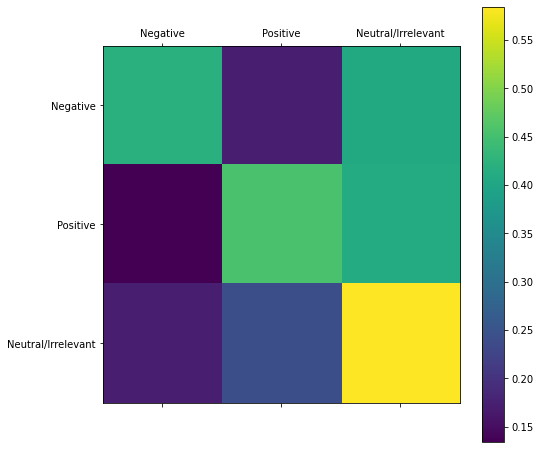

In [874]:
show_confusion_matrix(test_labels,classes_preds,list(classes))